If you have a liking for romantic movies, or sitcoms (no shame here!), you would probably have seen at least one or two people found love in New York City. Such as these people who find one another on the Empire State Building: 

![Sleepless in Seattle](https://typeset-beta.imgix.net/rehost%2F2016%2F9%2F13%2Fa9d29b21-a27e-408a-b335-7997afb9bc93.jpg)

Or this guy who spends 10 years telling his journey to find the woman of his dream:

![HIMYM](http://static.srcdn.com/wp-content/uploads/2016/10/How-I-Met-Your-Mother-Reunion.jpg)

The interesting question, are New Yorkers really *romantic*, or are they more *romanticized*? Taking advantage of the fact that New Yorkers commute a lot by taxis, and Valentine's Day 2016 was a Sunday, I would analyze the [NYC taxi dataset](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml) in order to hopefully uncover their Valentine's Day activities.

To get on the Valentine's Day trip with New Yorkers, first we need to invite all the guests needed for the trip:


In [1]:
library(ggplot2)
library(ggmap)
library(plyr)
library(dplyr)
trips = read.csv("valentine_trips.csv")

Warning message:
"package 'ggplot2' was built under R version 3.3.3"Warning message:
"package 'ggmap' was built under R version 3.3.3"Warning message:
"package 'plyr' was built under R version 3.3.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Let's have a peek of the dataset:

In [2]:
str(trips)

'data.frame':	402448 obs. of  14 variables:
 $ pickup_datetime  : Factor w/ 80910 levels "2016-02-14 00:00:00",..: 1 1 1 1 1 1 1 1 2 2 ...
 $ pickup_latitude  : num  40.6 40.8 40.7 40.6 40.7 ...
 $ pickup_longitude : num  -73.8 -74 -74 -73.8 -74 ...
 $ trip_distance    : num  17.14 16.84 1.12 12.55 1.51 ...
 $ passenger_count  : int  1 1 1 1 5 1 2 3 1 1 ...
 $ dropoff_datetime : Factor w/ 82633 levels "2016-02-14 00:00:00",..: 1 1 1 1 391 554 581 753 63 92 ...
 $ dropoff_latitude : num  40.7 40.6 40.8 40.7 40.8 ...
 $ dropoff_longitude: num  -73.8 -73.8 -74 -74 -74 ...
 $ fare_amount      : num  57 52 12 38 9 13 17.5 16.5 5.5 6 ...
 $ tolls_amount     : num  2.08 5.54 0 0 0 0 0 0 0 0 ...
 $ taxes_amount     : num  1.3 0.8 0.8 1.3 1.3 1.3 1.3 1.3 1.3 1.3 ...
 $ tip_amount       : num  0 0 14.08 0 3.09 ...
 $ payment_amount   : num  60.4 58.3 26.9 39.3 13.4 ...
 $ payment_type     : int  2 1 1 2 1 1 1 1 1 1 ...


How big is the dataset?

In [3]:
dim(trips)

[1] 402448     14

We can notice that the time taken for each trip is missing from the dataset, however we can easily calculate it in R:

In [4]:
# Convert datetime to POSIXct:
trips$pickup_datetime = as.POSIXct(trips$pickup_datetime)
trips$dropoff_datetime = as.POSIXct(trips$dropoff_datetime)
# Calculate time_taken:
trips$time_taken = as.numeric(trips$dropoff_datetime - trips$pickup_datetime, units = "mins")

We also need the rate of fare per mile of each trip:

In [5]:
trips$fare_per_mile = trips$fare_amount / trips$trip_distance

And of course, the time taken to travel per mile of each trip:

In [6]:
trips$time_per_mile = trips$time_taken / trips$trip_distance

To increase the effiency of our cleaning process, the next steps would be done by a helper function, `data_cleaning`.

In [7]:
data_cleaning = function(df){
    # filter time outliers:
    df = filter(df, time_taken > 0 & time_taken < 200)
    # filter inaccurate or missing data:
    df = filter(df, trip_distance > 0)
    df = filter(df, passenger_count > 0)
    df = filter(df, pickup_longitude != 0 & pickup_latitude != 0 & dropoff_longitude != 0 & dropoff_latitude != 0)
    # extract the trips that have a reasonable fare per mile*:
    df = filter(df, fare_per_mile >= 2 & fare_per_mile <= 10)
    # extract only credit card (1) and cash (2) payment: 
    df = filter(df, payment_type == 1 | payment_type == 2)
}

Looks good! Now we need to apply the function to our whole dataset:

In [8]:
trips = data_cleaning(trips)

In [9]:
dim(trips)

[1] 371619     17

More than 30,000 rows (almost 10%) have been gone! Imagine how they would affect our analysis! Now, we would want to calculate the number of dropoffs and pickups for each pair of dropoff coordinates in our dataset:

In [10]:
dropoff_counts <- trips %>% 
                    ddply(.(dropoff_longitude, dropoff_latitude), nrow) %>%
                    arrange(desc(V1))   

And of course, also for the pickup ones:

In [11]:
pickup_counts <- trips %>% 
                    ddply(.(pickup_longitude, pickup_latitude), nrow) %>%
                    arrange(desc(V1))   

Checking to see if our chain functions are doing fine:

In [12]:
head(dropoff_counts, n = 15)

dropoff_longitude,dropoff_latitude,V1
-73.95467,40.82100,49
-73.75566,40.71579,41
-73.93436,40.75362,29
-73.92770,40.77589,29
-73.91596,40.83654,28
-73.97175,40.74925,25
-73.94949,40.78788,24
-73.93951,40.75046,24
-73.98301,40.75048,18
-73.79343,40.65689,17


In [13]:
head(pickup_counts, n = 15)

pickup_longitude,pickup_latitude,V1
-73.95467,40.82100,49
-73.75566,40.71579,41
-73.93436,40.75362,30
-73.92770,40.77589,29
-73.91596,40.83654,28
-73.97175,40.74925,25
-73.94949,40.78788,24
-73.93951,40.75046,24
-73.98301,40.75048,17
-73.79343,40.65689,17


## The map of all pickups and dropoffs:

Now is the interesting part: mapping where they go. First, what we need to concern is the [minimum bounding box](https://en.wikipedia.org/wiki/Minimum_bounding_box) of New York City to ensure that the data points that are outside New York City wouldn't be mapped. 

In [14]:
min_lat = 40.5774
max_lat = 40.9176
min_long = -74.15
max_long = -73.7004

Now we would use some [helper functions](https://github.com/toddwschneider/nyc-taxi-data/tree/master/analysis) from [Todd W. Schneider](http://toddwschneider.com/) to ensure the aesthetic aspect of our maps:

In [15]:
alpha_range = c(0.14, 0.75)
size_range = c(0.134, 0.173)
title_with_subtitle = function(title, subtitle = "") {
  ggtitle(bquote(atop(bold(.(title)), atop(.(subtitle)))))
}

Wait no more! Here is the map of all the pickup coordinates. Note that the busier the pickup spot is, the lighter it will be on the map. The busiest spots would be in gold color:

In [16]:
plot_pickups <- ggplot(aes(x=pickup_longitude,y=pickup_latitude, alpha = V1, size = V1, col = V1),data=pickup_counts) +
            geom_point() +
            scale_x_continuous(limits=c(min_long, max_long)) +
            scale_y_continuous(limits=c(min_lat, max_lat)) +
            theme(panel.background = element_rect(fill = 'black', colour = 'black'), 
                  panel.grid.major = element_blank(), 
                  panel.grid.minor = element_blank())+
            scale_color_gradient(low="white", high="#ffd700", trans = "log") +
            scale_alpha_continuous(range = alpha_range, trans = "log", limits = range(pickup_counts$V1)) +
            scale_size_continuous(range = size_range, trans = "log", limits = range(pickup_counts$V1)) +
            theme(axis.text.x=element_blank()) +
            theme(axis.text.y=element_blank()) +
            theme(axis.title.y=element_blank()) +
            theme(axis.title.x=element_blank()) +
            theme(legend.position="none") +
            title_with_subtitle("New York City Taxi Pickups", "Valentine's Day 2016") +
            theme(plot.title=element_text(hjust = 0.5, margin=margin(b = -100, unit = "pt"), colour = "white"))

Warning message:
"Removed 54 rows containing missing values (geom_point)."

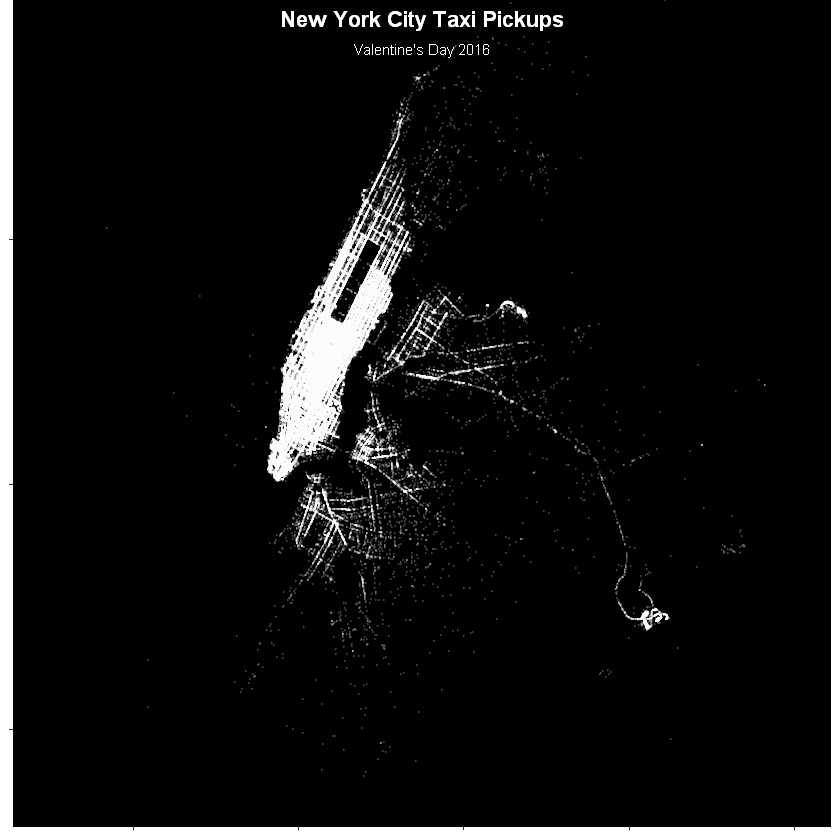

In [17]:
plot_pickups

In [18]:
plot_dropoffs <- ggplot(aes(x=dropoff_longitude,y=dropoff_latitude, alpha = V1, size = V1, col = V1),data=dropoff_counts) +
            geom_point() +
            scale_x_continuous(limits=c(min_long, max_long)) +
            scale_y_continuous(limits=c(min_lat, max_lat)) +
            theme(panel.background = element_rect(fill = 'black', colour = 'black'), 
                  panel.grid.major = element_blank(), 
                  panel.grid.minor = element_blank())+
            scale_color_gradient(low="white", high="#ffd700", trans = "log") +
            scale_alpha_continuous(range = alpha_range, trans = "log", limits = range(pickup_counts$V1)) +
            scale_size_continuous(range = size_range, trans = "log", limits = range(pickup_counts$V1)) +
            theme(axis.text.x=element_blank()) +
            theme(axis.text.y=element_blank()) +
            theme(axis.title.y=element_blank()) +
            theme(axis.title.x=element_blank()) +
            title_with_subtitle("New York City Taxi Dropoffs", "Valentine's Day 2016") +
            theme(legend.position="none") +
            theme(plot.title=element_text(hjust = 0.5, margin=margin(b = -100, unit = "pt"), colour = "white"))

Warning message:
"Removed 925 rows containing missing values (geom_point)."

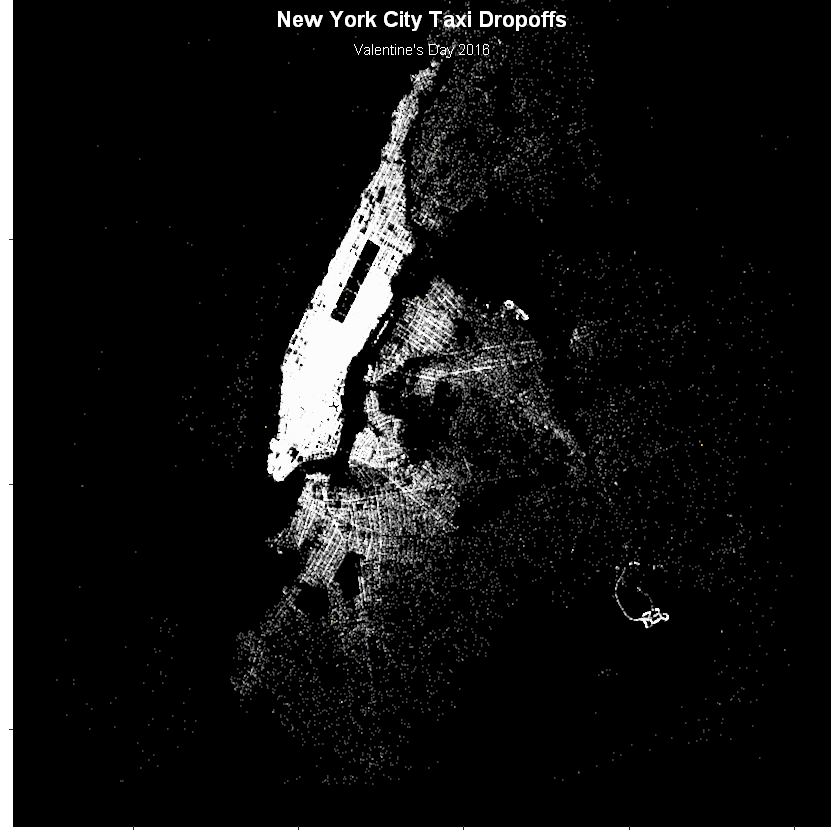

In [19]:
plot_dropoffs

We can see that while pickup are heavily concentrated at Manhattan, dropoffs are scattered a lot into other boroughs, which is the same observation that Todd S. made on his [analysis](http://toddwschneider.com/) of 1.1 billion taxi trips from 2009 to 2015. Guess New Yorkers generally don't go anywhere out of norm during a Valentine's Day weekend.

## The hot spots in Manhattan:

Now, we can see that Manhattan is all lit up (well, literally), but what are the hottest spots in Manhattan on Valentine's Day? Let's see! 

First, we can use `ggmap` to pull the map of Manhattan from Google Maps API.

In [20]:
Manhattan_map <- get_map("Manhattan",maptype="roadmap", zoom = 12)

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=Manhattan&zoom=12&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Manhattan&sensor=false


Next, we can do the mapping. The bigger and darker a circle is, the busier the spot is.

Warning message:
"Removed 45 rows containing missing values (geom_point)."

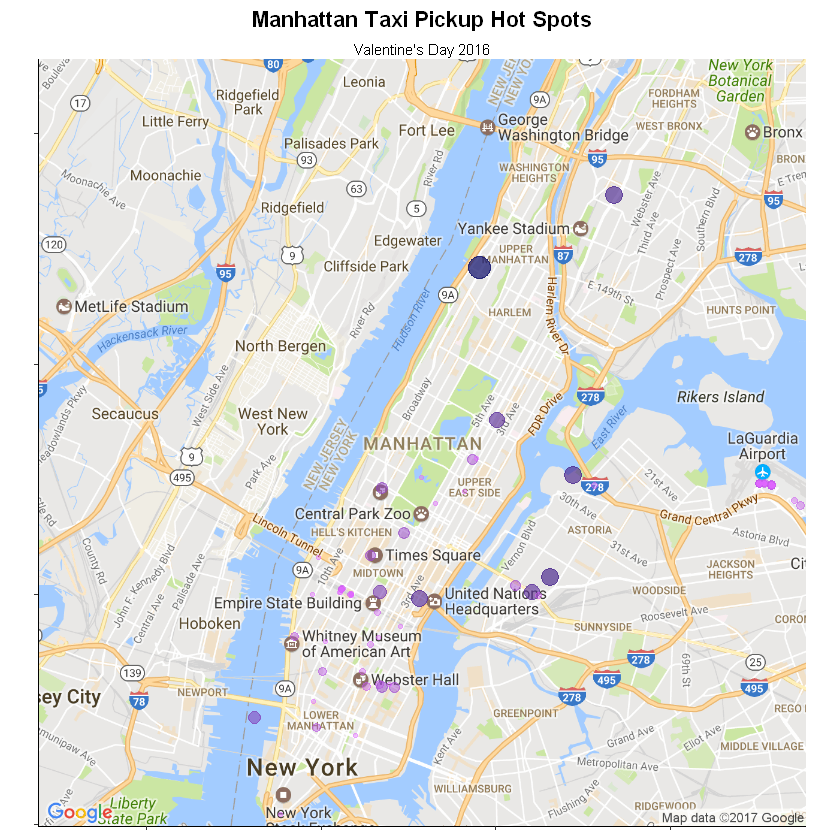

In [21]:
map_pickups <- ggmap(Manhattan_map) +
            geom_point(aes(x=pickup_longitude,y=pickup_latitude, alpha = V1, size = V1, col = V1),data=pickup_counts %>% filter(V1 >= 5)) +
            theme(panel.background = element_rect(fill = 'black', colour = 'black'), 
                  panel.grid.major = element_blank(), 
                  panel.grid.minor = element_blank())+
            scale_color_gradient(low="mediumorchid1", high="midnightblue", trans = "log") +
            scale_alpha_continuous(range = alpha_range, trans = "log", limits = range(pickup_counts$V1)) +
            theme(axis.text.x=element_blank()) +
            theme(axis.text.y=element_blank()) +
            theme(axis.title.y=element_blank()) +
            theme(axis.title.x=element_blank()) +
            theme(legend.position="none") +
            theme(plot.title=element_text(hjust = 0.5, margin=margin(b = -10, unit = "pt"))) +
            title_with_subtitle("Manhattan Taxi Pickup Hot Spots", "Valentine's Day 2016") 
map_pickups

Warning message:
"Removed 9 rows containing missing values (geom_point)."

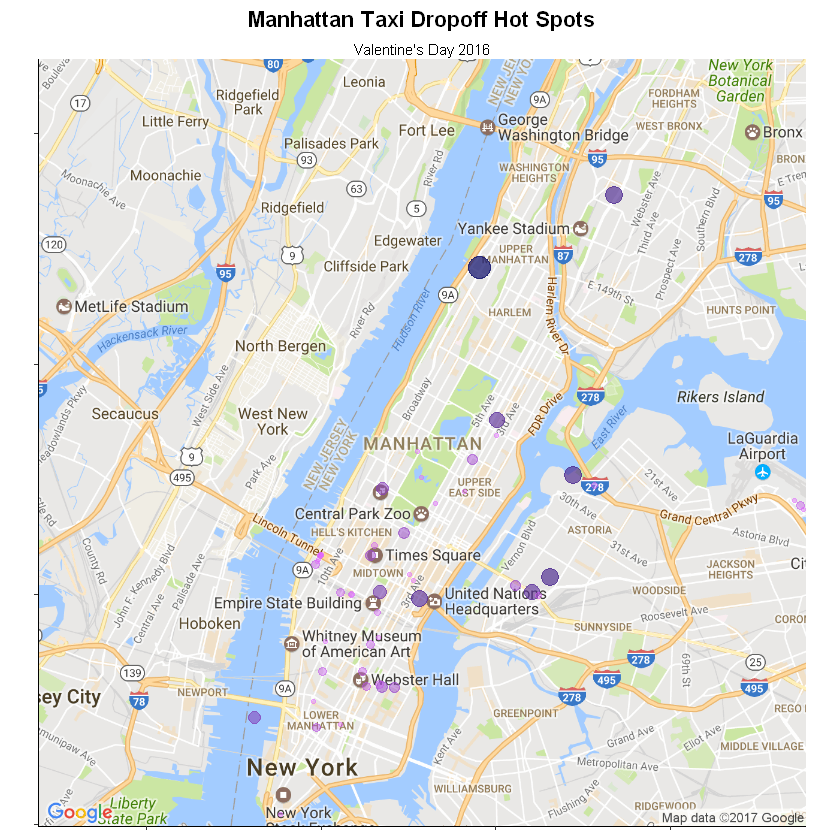

In [22]:
map_dropoffs <- ggmap(Manhattan_map) +
            geom_point(aes(x=dropoff_longitude,y=dropoff_latitude, alpha = V1, size = V1, col = V1),data=dropoff_counts %>% filter(V1 >= 5)) +
            theme(panel.background = element_rect(fill = 'black', colour = 'black'), 
                  panel.grid.major = element_blank(), 
                  panel.grid.minor = element_blank())+
            scale_color_gradient(low="mediumorchid1", high="midnightblue", trans = "log") +
            scale_alpha_continuous(range = alpha_range, trans = "log", limits = range(pickup_counts$V1)) +
            theme(axis.text.x=element_blank()) +
            theme(axis.text.y=element_blank()) +
            theme(axis.title.y=element_blank()) +
            theme(axis.title.x=element_blank()) +
            theme(legend.position="none") +
            theme(plot.title=element_text(hjust = 0.5, margin=margin(b = -10, unit = "pt"))) +
            title_with_subtitle("Manhattan Taxi Dropoff Hot Spots", "Valentine's Day 2016") 
map_dropoffs

We can see that the busiest spots for both picking up and dropping off are almost alike, which indeed makes sense, as the people have been dropped off at the spots would need taxis to pick them up. As we can predict, areas around the famous tourist attractions in NYC such as Time Square, Empire State Building, Webster Hall, Central Zetc... are pretty busy. However, what location does the busiest spot in Upper Manhattan belong to? For the sake of our curiosity, we can use function `revgeocode` in the `ggmap` package to do a little detective work. We can get the coordinates of that location from our coordinate count tables above:

In [23]:
revgeocode(c(-73.97175, 40.74925))

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.74925,-73.97175&sensor=false


[1] "310 E 42nd St, New York, NY 10017, USA"

A little more googling would reveal that it is the [Church of the Covenant](https://www.yelp.com/biz/church-of-the-covenant-new-york) in New York. If you forget, Valentine's Day 2016 was on a Sunday. And of course, people go to church on Sunday. 

## Conclusion:

Comparing to the maps of pickups and dropoffs of 1.1 billion taxi trips that Todd S. made, we can see that our pickup and dropoff maps don't really differ. Life went on pretty normality on a Valentine's weekend for most people. The majority of traffic don't go anywhere out of norm. A lot of people still went to church and normal weekend activities, while other spent time in midtown around the famous landmarks in NYC.

So unfortunately, we can't measure how romantic New Yorkers based on their taxi activity on a Valentine's Day (and I am not really sure if *romance* is even a quantitative measurement. Maybe in movies, romance is to quit your job and move to a new town in a heartbeat; in reality, to live life with responsibility and stability is a kind of romance.